In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [3]:
@load "../data/sim2data.jld";

In [4]:
# priors #
μβ = fill(0.0, p, q); inv_Vr = [[0.0 0.0]; [0.0 0.0]]; # set Vr^{-1} be zero for the simulation...
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];
inv_Lr = [[0.0 0.0]; [0.0 0.0]]; Lμβ = inv_Lr * μβ;

In [5]:
# Some data preparations #
S_ind = [sort(S1_ind), sort(S2_ind)];
S = sort(union(S_ind[1], S_ind[2]));
M_ind = [sort(setdiff(S, S_ind[i])) for i in 1:length(S_ind)];                                  # in S not in Si
M = sort(union(M_ind[1], M_ind[2]));
R = setdiff(S, M);                                            # reference set of NNGP
U2 = setdiff(1:N, S);                                         # locations with no observations
U = union(M, U2);                                             # locations for prediction

NR = length(R);
NS = length(S);
NM = length(M);
NU = length(U);
NU2 = length(U2);

v1 = zeros(N); v1[M_ind[1]] .= 1;
v2 = zeros(N); v2[M_ind[2]] .= 1;
index_M = (2^0 * v1 + 2^1 * v2);                              # build index indicating which response are observed
M_Mind = [findall(x -> x == 2^(i - 1), index_M[M]) for i in 1:length(S_ind)];   # index of M_ind among M


m = 10;                                                       # number of nearest neighbor                       
NN = BuildNN(coords_ord[R, :], m);                       # build nearest neighbor 
nnIndx_col = vcat(NN.nnIndx, 1:NR);                           # the index of columns
nnIndx_row = zeros(Int64, 0);                                               
for i in 2:m
    nnIndx_row = vcat(nnIndx_row, fill(i, i-1))
end
nnIndx_row = vcat(nnIndx_row, repeat((m + 1):NR, inner = m), 1:NR);  # the index of rows

In [6]:
# cross-validation Preparison
# (a) Randomly split S into K folder 
Random.seed!(321); #1 11 1234
kf = 5;
parts = kfoldperm(NR,kf);

# (b) Build NN index for training data in ith folder
using RCall
CVNN_train = Array{Any,1}(undef, kf);
CVNN_test = Array{Any,1}(undef, kf);
CVnnIndx_col = Array{Any,1}(undef, kf);
CVnnIndx_row = Array{Any,1}(undef, kf);
CVMnnIndxLU = Array{Any,1}(undef, kf); 
CVMnnIndx = Array{Any,1}(undef, kf);
@rput coords_ord
@rput R
@rput m
@rput parts

for i in 1:kf
    
    # Build NN index for training data in ith folder
    CVNN_train[i] = BuildNN(coords_ord[R[filter(x->!(x in parts[i]), eachindex(R))], :], m);
    CVnnIndx_col[i] = vcat(CVNN_train[i].nnIndx, 1:(NR - length(parts[i])));
    CVnnIndx_row[i] = zeros(Int64, 0);
    for j in 2:m
        CVnnIndx_row[i] = vcat(CVnnIndx_row[i], fill(j, j - 1));
    end
    CVnnIndx_row[i] = vcat(CVnnIndx_row[i], 
        repeat((m + 1):(NR - length(parts[i])), inner = m), 1:(NR - length(parts[i])));
        
    # Build nearest neighbor index for holdout locations
    @rput i
    R"""
    library("RANN")
    nn_mod_ho <- nn2(coords_ord[R[-parts[[i]]], ], coords_ord[R[parts[[i]]], ], k = m)
    """
    @rget nn_mod_ho
    CVNN_test[i] = nn_mod_ho;
    CVMnnIndxLU[i] = collect(1:m:(length(parts[i]) * m + 1));
    CVMnnIndx[i] = vec(nn_mod_ho[:nn_idx]');  
end   

In [7]:
# (a) grid of candidate value
ϕ_grid = vcat(LinRange(3 / sqrt(2), 3 * 12.5 / sqrt(2), 25))
#LinRange(3 / sqrt(2), 3 * 50 / sqrt(2), 20) #LinRange(3 / sqrt(2), 3 * 100 / sqrt(2), 20);
α_grid = vcat(LinRange(0.8, 0.99, 25)) #LinRange(0.75, 1, 10); #LinRange(0.5, 1, 10);

In [8]:
# For loop
CVRMSPE2 = fill(0.0, length(ϕ_grid), length(α_grid), kf);
CVPrecond_D = Array{Any,1}(undef, kf);
prog = Progress(kf, 1, "Computing initial pass...", 50)
#@time Threads.@threads                    # can run parallel computing
for i in 1:kf
    CVnIndx = length(CVNN_train[i].nnIndx);
    nk = length(parts[i]);
    CVA = Array{Float64}(undef, CVnIndx); CVD = Array{Float64}(undef, NR - nk);
    Index_train = [filter(x->!(x in parts[i]), eachindex(R))][1];
    CVVK = []; CVXstar = []; CVYstar = []; CVμstar = [];
    
    CVAtilde = Array{Float64}(undef, nk * m); CVDtilde = Array{Float64}(undef, nk);
    CVAtildeM = [];
    
    for j in 1:length(ϕ_grid) 
        for k in 1:length(α_grid)
            
            # obtain posterior estimators of beta
            getAD(coords_ord[R[Index_train], :], 
                CVNN_train[i].nnIndx, CVNN_train[i].nnDist, CVNN_train[i].nnIndxLU, 
                ϕ_grid[j], 0.5, CVA, CVD);
            CVVK = Diagonal(1 ./ sqrt.(CVD)) * (sparse(CVnnIndx_row[i], 
                    CVnnIndx_col[i], vcat(-CVA, ones(NR - nk))));
            CVa = sqrt(α_grid[k] / (1 - α_grid[k]));
            CVXstar = sparse(vcat(repeat(1:(NR - nk), 3), repeat((NR - nk + 1):(NR - nk + p), p)), 
                vcat(repeat(1:p, inner = NR - nk), (1 + p):(NR - nk + p), repeat(1:p, inner = p)), 
                vcat(vec(CVa * X_ord[R[Index_train], :]), CVa * ones(NR - nk), 
                    vec(inv_Lr)), (2 * (NR - nk) + p), (p + NR - nk));
            CVXstar[(NR - nk + p + 1): (2 * (NR - nk) + p), (p + 1):(NR - nk + p)] = CVVK;
            CVYstar = vcat(CVa * Y_ord[R[Index_train], :], Lμβ, fill(0.0, (NR - nk, q)));
            CVμstar = fill(0.0, NR - nk + p, q)
            for l in 1:q
                CVμstar[:, l] = lsmr(CVXstar, CVYstar[:, l]);
            end

            # obtain posterior predictions over holded folder
            getAD(coords_ord[R[Index_train], :], CVMnnIndx[i], 
                vec(CVNN_test[i][:nn_dists]'), CVMnnIndxLU[i],  ϕ_grid[j], 0.5, CVAtilde, CVDtilde)
            CVAtildeM = sparse(repeat(1:nk, inner = m), CVMnnIndx[i], CVAtilde, nk, NR - nk);
            Y_hold_mean = X_ord[R[parts[i]], :] * CVμstar[1:p, 1:q] + 
                CVAtildeM * CVμstar[(p + 1):(p + NR - nk), 1:q];
            
            # Calculate RMSPE
            CVRMSPE2[j, k, i] = CVRMSPE2[j, k, i] + sqrt(mean((Y_ord[R[parts[i]], :] - Y_hold_mean).^2));
        end
    end
    next!(prog) # monitor the progress
end
CVRMSPE = [sum(CVRMSPE2[j, k, :]) for j in 1:length(ϕ_grid), k in 1:length(α_grid)];

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:15


In [9]:
# cross-validation for choosing delta and phi ...
pick_ind = argmin(CVRMSPE);
ϕ_pick = ϕ_grid[pick_ind[1]]; α_pick = α_grid[pick_ind[2]]; # alpha ranges from 0 to 1. alpha = sigma2 / (sigma2 + tau2)
round.([ϕ_pick, α_pick], digits = 3)

2-element Array{Float64,1}:
 3.138
 0.95 

In [10]:
# Build μ* V* Ψ* v*

# (a) Lr-1 and Lr-1μβ

# (b) Construct Xstar Ystar
nIndx = length(NN.nnIndx);
A = Array{Float64}(undef, nIndx); D = Array{Float64}(undef, NR);
getAD(coords_ord[R, :], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_pick, 0.5, A, D);
VK = Diagonal(1 ./ sqrt.(D)) * (sparse(nnIndx_row, nnIndx_col, vcat(-A, ones(NR))));
a = sqrt(α_pick / (1 - α_pick));
Xstar = sparse(vcat(repeat(1:NR, p + 1), repeat((NR + 1):(NR + p), p)), 
        vcat(repeat(1:p, inner = NR), (1 + p):(NR + p), repeat(1:p, inner = p)), 
        vcat(vec(a * X_ord[R, :]), a * ones(NR), vec(inv_Lr)), (2 * NR + p), (p + NR));
Xstar[(NR + p + 1): (2 * NR + p), (p + 1):(NR + p)] = VK;
Ystar = vcat(a * Y_ord[R, :], Lμβ, fill(0.0, (NR, q)));
# (c) obtain μstar ψstar and νstar
μstar = fill(0.0, NR + p, q)
for i in 1:q
    μstar[:, i] = lsmr(Xstar, Ystar[:, i]);
end
u = Ystar - Xstar * μstar;
Ψstar = ΨΣ + u'u; νstar = νΣ + NR;

In [11]:
# construct Atilde Dtilde #

using RCall
@rput coords_ord
@rput R
@rput U
@rput m
R"""
library("RANN")
nn_mod_ho <- nn2(coords_ord[R, ], coords_ord[U, ], k = m)
"""
@rget nn_mod_ho
nm = length(U);
Atilde = Array{Float64}(undef, nm * m); Dtilde = Array{Float64}(undef, nm);
MnnIndxLU = collect(1:m:(nm * m + 1));
MnnIndx = vec(nn_mod_ho[:nn_idx]');
getAD(coords_ord[R, :], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, 
    ϕ_pick, 0.5, Atilde, Dtilde)
AtildeM = sparse(repeat(1:nm, inner = m), MnnIndx .+ p, Atilde, nm, NR + p);
DtildeD = Diagonal(sqrt.(Dtilde));

In [12]:
# Preallocation for posterior samples #
N_sam = 500;
γ_sam = Array{Float64, 3}(undef, p + NR, q, N_sam);
Σ_sam = Array{Float64, 3}(undef, q, q, N_sam);
#ω_sam = Array{Float64, 3}(undef, n, q, N_sam);
ω_M_sam = Array{Float64, 3}(undef, nm, q, N_sam);
Y_M_sam = Array{Float64, 3}(undef, nm, q, N_sam);   # missing value

cholΣ_sam = Array{Float64, 2}(undef, q, q);
eta = fill(0.0, (2 * NR + p, q)); v = fill(0.0, (NR + p, q)); z = fill(0.0, (nm, q));

In [13]:
# generate the posterior samples #
Random.seed!(123);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    
    Σ_sam[:, :, l] = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    cholΣ_sam = cholesky(Σ_sam[:, :, l]);
    eta = rand(Normal(), 2 * NR + p, q) * cholΣ_sam.U;
    #Precond_D = colnorm(Xstar);
    for i in 1:q
        #v[:, i] = Diagonal(1 ./ Precond_D) * lsmr(Xstar * Diagonal(1 ./ Precond_D), eta[:, i])
        v[:, i] = lsmr(Xstar, eta[:, i])
    end
    γ_sam[:, :, l] = v + μstar;
    
    z = rand(Normal(), nm, q) * cholΣ_sam.U;
    ω_M_sam[:, :, l] = AtildeM * γ_sam[:, :, l] + DtildeD * z
    
    z = rand(Normal(), nm, q) * cholΣ_sam.U;
    Y_M_sam[:, :, l] = X_ord[U, :] * γ_sam[1:p, 1:q, l] + ω_M_sam[:, :, l] + 1 / a * z
    next!(prog) # monitor the progress
end

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:01


# MCMC Chain check

In [14]:
# packages for diagnostic test
using StatsPlots
using MCMCChains
using PrettyTables

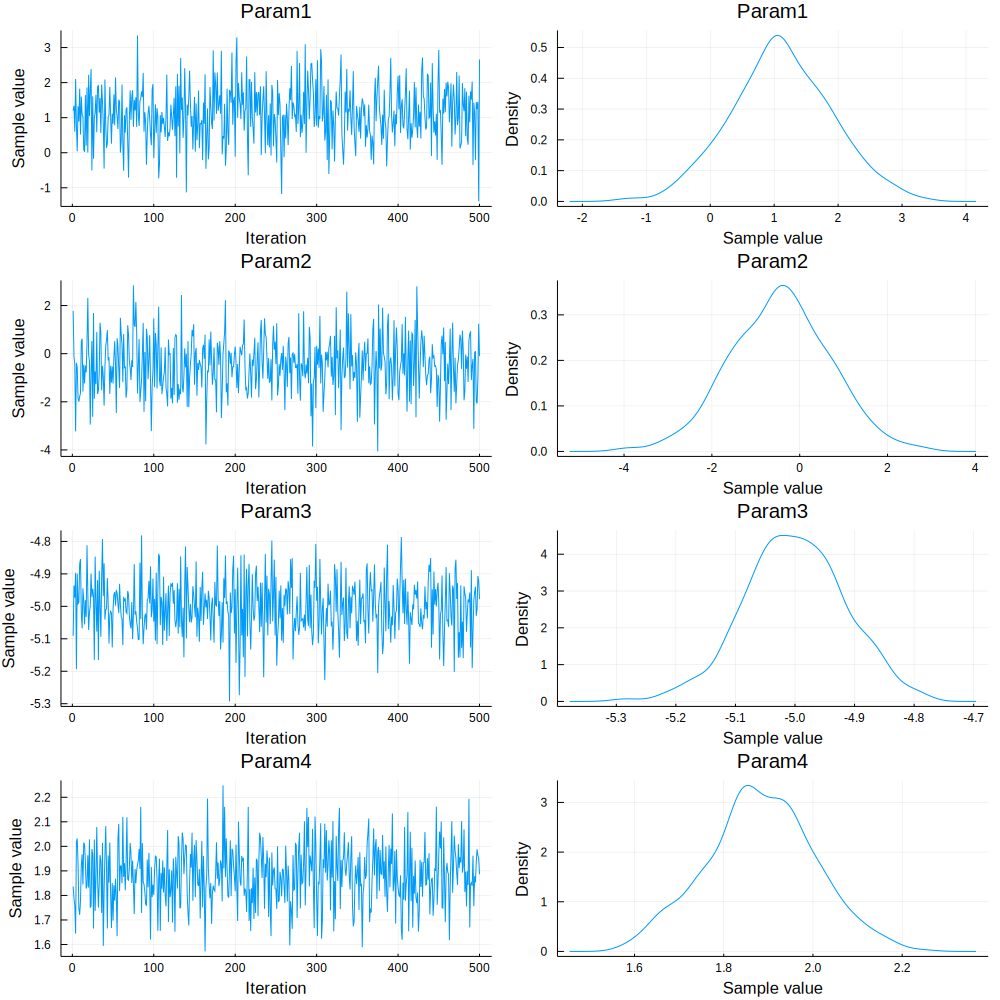

In [15]:
β_pos_sam = Array{Float64, 3}(undef, N_sam, p * q, 1);
β_pos_sam[:, :, 1] = hcat(γ_sam[1, 1, :], γ_sam[1, 2, :], γ_sam[2, 1, :], γ_sam[2, 2, :]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

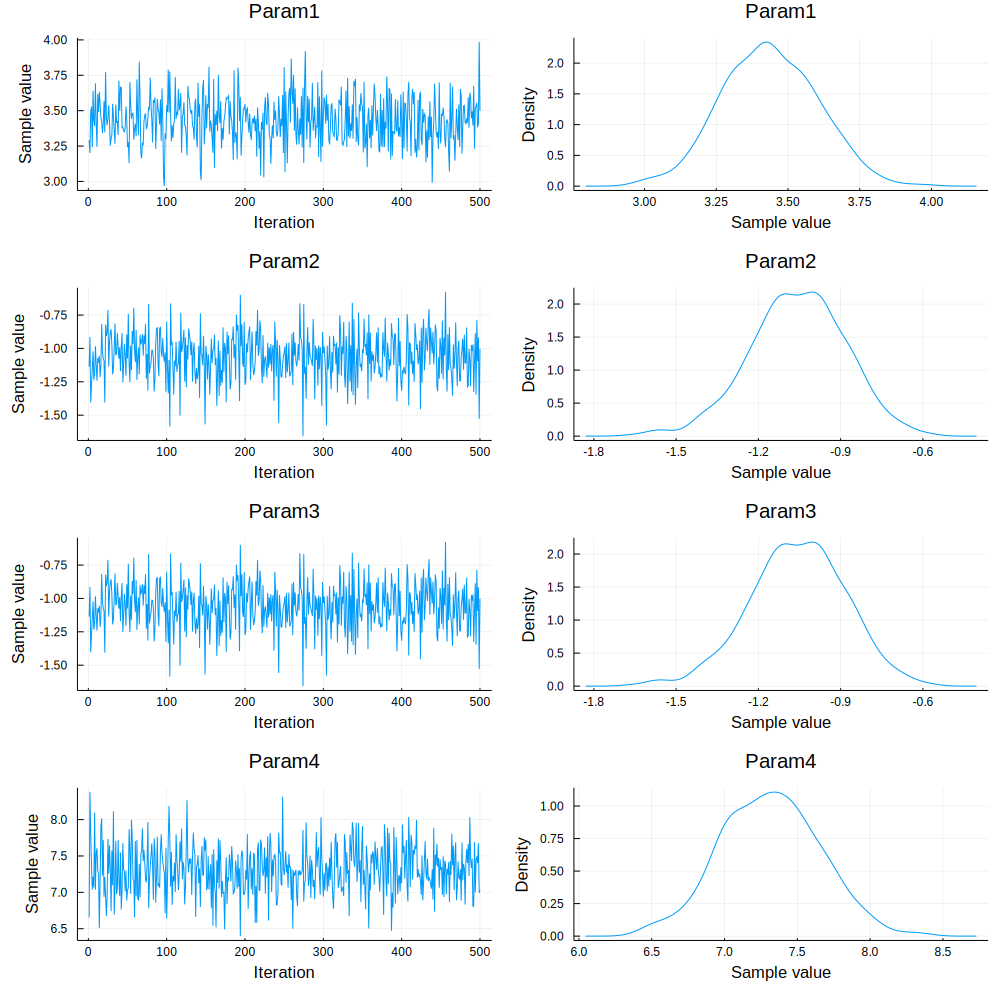

In [16]:
truncindex = 1; #Integer(trunc(N_sam / 2));
Σ_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, truncindex:N_sam], Σ_sam[1, 2, truncindex:N_sam], 
    Σ_sam[2, 1, truncindex:N_sam], Σ_sam[2, 2, truncindex:N_sam]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

In [17]:
Σ

2×2 Array{Float64,2}:
 0.3  0.0
 0.0  0.2

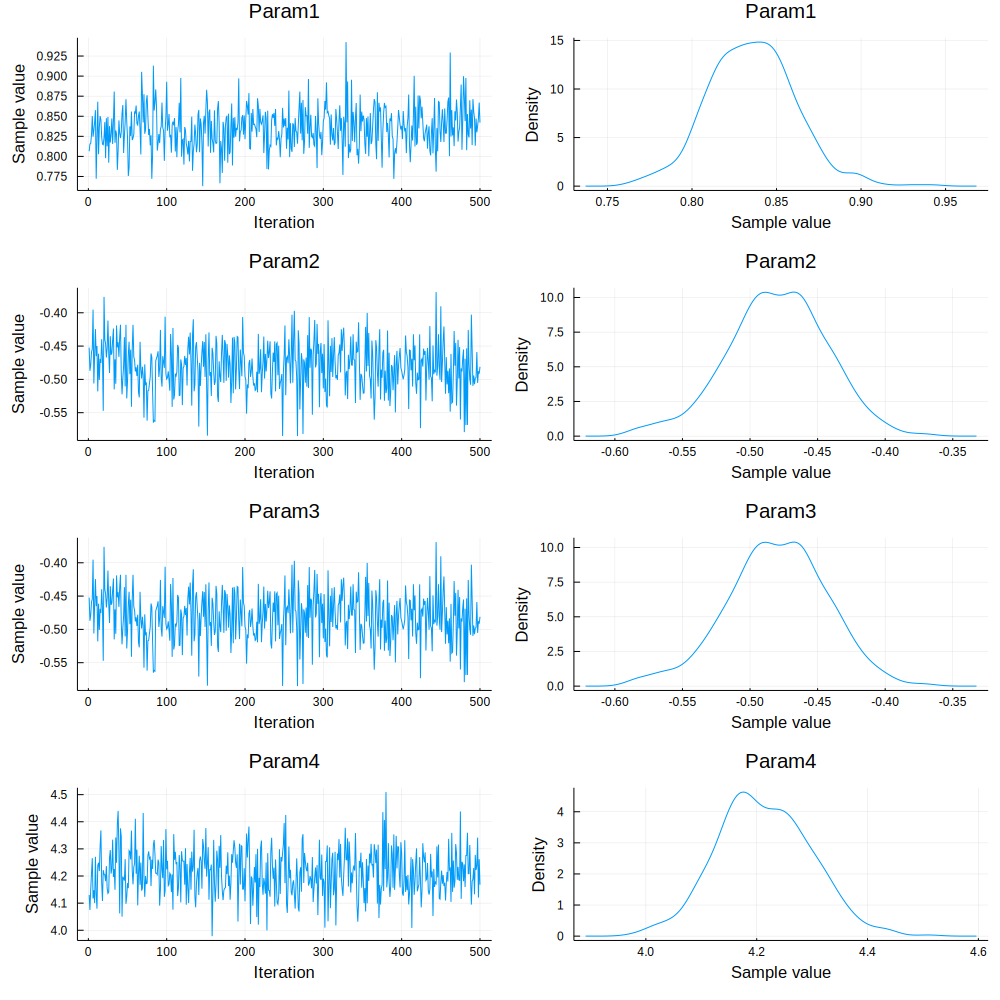

In [18]:
# check the variance covariance across latent process
cov_pos = Array{Float64, 3}(undef, q, q, N_sam);
for i in 1:N_sam
    cov_pos[:, :, i] = cov(γ_sam[(p + 1):(p + NR), :, i])
end   
# ω_incp_obs_pos_sam[:, :, i]
cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
cov_pos_sam[:, :, 1] = hcat(cov_pos[1, 1, :], cov_pos[1, 2, :], 
    cov_pos[2, 1, :], cov_pos[2, 2, :]);
cov_pos_chain = Chains(cov_pos_sam);
pcov = plot(cov_pos_chain)

In [19]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
  0.683048  -0.615677
 -0.615677   4.51697 

In [20]:
γ_sam;

# Posterior Inference 

In [21]:
# CVG #
N_Inf_burn = 1;
Y_M_pos_qt = Array{Float64, 3}(undef, nm, q, 3);
Y_M_pos_mean = Array{Float64, 2}(undef, nm, q);
for j in 1:q
    for i in 1:nm
        Y_M_pos_qt[i, j, :] = quantile(Y_M_sam[i, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
        Y_M_pos_mean[i, j] = mean(Y_M_sam[i, j, N_Inf_burn:N_sam])
    end
end
# count the covarage of 95% CI #
count_Y_M = fill(0.0, 2);
for j in 1:q
    for i in 1:length(M_ind[j])
        count_Y_M[j] = count_Y_M[j] + 
        ((Y_M_pos_qt[M_Mind[j][i], j, 1] < Y_ord[U[M_Mind[j][i]], j]) && 
            (Y_M_pos_qt[M_Mind[j][i], j, 3] > Y_ord[U[M_Mind[j][i]], j]))
    end
end
for j in 1:q
    for i in 1:NU2
        count_Y_M[j] = count_Y_M[j] + 
        ((Y_M_pos_qt[i + NM, j, 1] < Y_ord[U[i + NM], j]) && 
            (Y_M_pos_qt[i + NM, j, 3] > Y_ord[U[i + NM], j]))
    end
end

print(round.([count_Y_M[i] / (length(M_ind[i]) + NU2) for i in 1:2], digits = 3));
print(round(sum(count_Y_M) / (length(M_ind[1]) + length(M_ind[2]) + 2 * NU2), digits = 3));

[0.935, 0.955]0.945

In [22]:
# RMSPE #
SPE1 = sum((Y_ord[U[M_Mind[1]], 1] - Y_M_pos_mean[M_Mind[1], 1]).^2) + 
    sum((Y_ord[U[(NM + 1):NU], 1] - Y_M_pos_mean[(NM + 1):NU, 1]).^2)
RMSPE1 = sqrt(SPE1 / (length(M_ind[1]) + NU2));
SPE2 = sum((Y_ord[U[M_Mind[2]], 2] - Y_M_pos_mean[M_Mind[2], 2]).^2) + 
    sum((Y_ord[U[(NM + 1):NU], 2] - Y_M_pos_mean[(NM + 1):NU, 2]).^2)
RMSPE2 = sqrt(SPE2 / (length(M_ind[2]) + NU2));
MSPE = (SPE1 + SPE2) / (length(M_ind[1]) + length(M_ind[2]) + 2 * NU2);
RMSPE = sqrt(MSPE);
round.([RMSPE1 RMSPE2 RMSPE], digits = 3)

1×3 Array{Float64,2}:
 0.676  0.976  0.839

In [23]:
# CVGL #
N_Inf_burn = 1;
ω_pos_qt = Array{Float64, 3}(undef, NR, q, 3);
ω_pos_mean = Array{Float64, 2}(undef, NR, q);
for j in 1:q
    for i in 1:NR
        ω_pos_qt[i, j, :] = quantile(γ_sam[i + p, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
        ω_pos_mean[i, j] = mean(γ_sam[i + p, j, N_Inf_burn:N_sam])
    end
end

ω_M_pos_qt = Array{Float64, 3}(undef, NU, q, 3);
ω_M_pos_mean = Array{Float64, 2}(undef, NU, q);
for j in 1:q
    for i in 1:NU
        ω_M_pos_qt[i, j, :] = quantile(ω_M_sam[i, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
        ω_M_pos_mean[i, j] = mean(ω_M_sam[i, j, N_Inf_burn:N_sam])
    end
end

# count the covarage of 95% CI #
count_ω = fill(0.0, 2);
for j in 1:q
    for i in 1:length(M_Mind[3-j])     # use 3-j since q = 2
        count_ω[j] = count_ω[j] + 
        ((ω_M_pos_qt[M_Mind[3-j][i], j, 1] < ω_ord[U[M_Mind[3-j][i]], j]) && 
            (ω_M_pos_qt[M_Mind[3-j][i], j, 3] > ω_ord[U[M_Mind[3-j][i]], j]))
    end
end

for j in 1:q
    for i in 1:NR
        count_ω[j] = count_ω[j] + 
        ((ω_pos_qt[i, j, 1] < ω_ord[R[i], j]) && 
            (ω_pos_qt[i, j, 3] > ω_ord[R[i], j]))
    end
end
print(round.([count_ω[i] / length(S_ind[i]) for i in 1:q], digits = 3));
print(round(sum(count_ω) / (length(S_ind[1]) + length(S_ind[2])), digits = 3))

[1.0, 0.999]1.0

In [24]:
# CVGL2 #
N_Inf_burn = 1;
ω_incp_pos_qt = Array{Float64, 3}(undef, NR, q, 3);
ω_incp_pos_mean = Array{Float64, 2}(undef, NR, q);
ω_incp_pos_var = Array{Float64, 2}(undef, NR, q);
for j in 1:q
    for i in 1:NR
        ω_incp_pos_qt[i, j, :] = quantile(γ_sam[i + p, j, N_Inf_burn:N_sam] + 
            γ_sam[1, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
        ω_incp_pos_mean[i, j] = mean(γ_sam[i + p, j, N_Inf_burn:N_sam] + 
            γ_sam[1, j, N_Inf_burn:N_sam]);
        ω_incp_pos_var[i, j] = var(γ_sam[i + p, j, N_Inf_burn:N_sam] + 
            γ_sam[1, j, N_Inf_burn:N_sam])
    end
end

ω_incp_M_pos_qt = Array{Float64, 3}(undef, NU, q, 3);
ω_incp_M_pos_mean = Array{Float64, 2}(undef, NU, q);
ω_incp_M_pos_var = Array{Float64, 2}(undef, NU, q);
for j in 1:q
    for i in 1:NU
        ω_incp_M_pos_qt[i, j, :] = quantile(ω_M_sam[i, j, N_Inf_burn:N_sam] +
            γ_sam[1, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
        ω_incp_M_pos_mean[i, j] = mean(ω_M_sam[i, j, N_Inf_burn:N_sam] + 
            γ_sam[1, j, N_Inf_burn:N_sam]);
        ω_incp_M_pos_var[i, j] = var(ω_M_sam[i, j, N_Inf_burn:N_sam] + 
            γ_sam[1, j, N_Inf_burn:N_sam]);
    end
end


# count the covarage of 95% CI #
count_ω_incp = fill(0.0, 2);

for j in 1:q
    for i in 1:length(M_Mind[3-j])     # use 3-j since q = 2
        count_ω_incp[j] = count_ω_incp[j] + 
        ((ω_incp_M_pos_qt[M_Mind[3-j][i], j, 1] < (ω_ord[U[M_Mind[3-j][i]], j] + β[1, j])) && 
            (ω_incp_M_pos_qt[M_Mind[3-j][i], j, 3] > (ω_ord[U[M_Mind[3-j][i]], j] + β[1, j])))
    end
end

for j in 1:q
    for i in 1:NR
        count_ω_incp[j] = count_ω_incp[j] + 
        ((ω_incp_pos_qt[i, j, 1] < (ω_ord[R[i], j] + β[1, j]) )  && 
            (ω_incp_pos_qt[i, j, 3] > (ω_ord[R[i], j] + β[1, j])))
    end
end

print(round.([count_ω_incp[i] / length(S_ind[i]) for i in 1:q], digits = 3));
print(round(sum(count_ω_incp) / (length(S_ind[1]) + length(S_ind[2])), digits = 3))

[0.925, 0.957]0.941

In [25]:
# MSEL #
SEL1 = sum((ω_ord[R, 1] - ω_pos_mean[:, 1]).^2) + sum((ω_ord[U[M_Mind[2]], 1] - ω_M_pos_mean[M_Mind[2], 1]).^2);
MSEL1 = SEL1 / length(S_ind[1]);
SEL2 = sum((ω_ord[R, 2] - ω_pos_mean[:, 2]).^2) + sum((ω_ord[U[M_Mind[1]], 2] - ω_M_pos_mean[M_Mind[1], 2]).^2);
MSEL2 = SEL2 / length(S_ind[2]);
MSEL = (SEL1 + SEL2)/(length(S_ind[1]) + length(S_ind[2]));
round.([MSEL1 MSEL2 MSEL], digits = 3)

1×3 Array{Float64,2}:
 0.175  0.549  0.362

In [26]:
# MSEL2 of intercept-centered latent process#
SEL1 = sum((ω_ord[R, 1] .+ β[1, 1] - ω_incp_pos_mean[:, 1]).^2) + 
  sum((ω_ord[U[M_Mind[2]], 1] .+ β[1, 1] - ω_incp_M_pos_mean[M_Mind[2], 1]).^2);
MSEL1 = SEL1 / length(S_ind[1]);
SEL2 = sum((ω_ord[R, 2] .+ β[1, 2] - ω_incp_pos_mean[:, 2]).^2) +
  sum((ω_ord[U[M_Mind[1]], 2] .+ β[1, 2] - ω_incp_M_pos_mean[M_Mind[1], 2]).^2);
MSEL2 = SEL2 / length(S_ind[2]);
MSEL = (SEL1 + SEL2)/(length(S_ind[1]) + length(S_ind[2]));
round.([MSEL1 MSEL2 MSEL], digits = 3)

1×3 Array{Float64,2}:
 0.16  0.292  0.226

In [27]:
Y_M_sam_var = [var(Y_M_sam[i, j, :]) for i in 1:NU, j in 1:2];
Y_M_sam_mean = [mean(Y_M_sam[i, j, :]) for i in 1:NU, j in 1:2];
v1 = zeros(N); v1[S1_ind] .= 1;
v2 = zeros(N); v2[S2_ind] .= 1;
index_S = (2^0 * v1 + 2^1 * v2);                              # build index indicating which response are observed
U1_Uind = findall(x -> (x == 2^1 || x == 0), index_S[U]);     # index of unobserved location among U
U2_Uind = findall(x -> (x == 2^0 || x == 0), index_S[U]);     # index of unobserved location among U

In [28]:
# CRPS #
CRPS_U = [(sqrt(Y_M_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[U[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) -
        ((Y_ord[U[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[U[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) - 1)))
        for i in 1:length(U), j in 1:q];

CRPS1 = (sum(CRPS_U[U1_Uind, 1]) ) / (N - length(S1_ind));
CRPS2 = (sum(CRPS_U[U2_Uind, 2]) ) / (N - length(S2_ind));
CRPS = (sum(CRPS_U[U1_Uind, 1]) + sum(CRPS_U[U2_Uind, 2])) /
(2*N - length(S1_ind) - length(S2_ind));
round.([CRPS1 CRPS2 CRPS], digits = 3)

1×3 Array{Float64,2}:
 -0.384  -0.551  -0.467

In [29]:
S1_Uind = findall(x -> (x == 2^0), index_S[U]);     # index of unobserved location among U
S2_Uind = findall(x -> (x == 2^1), index_S[U]);     # index of unobserved location among U

In [30]:
# CRPSL over 1000 observed locations#
CRPSL_R = [(sqrt(ω_incp_pos_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[R[i], j] - ω_incp_pos_mean[i, j]) / sqrt(ω_incp_pos_var[i, j])) -
        ((ω_incp_obs[R[i], j] - ω_incp_pos_mean[i, j]) / sqrt(ω_incp_pos_var[i, j])) * 
        (2* cdf(Normal(), (ω_incp_obs[R[i], j] - ω_incp_pos_mean[i, j]) / sqrt(ω_incp_pos_var[i, j])) - 1)))
        for i in 1:NR, j in 1:q];

CRPSL_U = [(sqrt(ω_incp_M_pos_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[U[i], j] - ω_incp_M_pos_mean[i, j]) / sqrt(ω_incp_M_pos_var[i, j])) -
        ((ω_incp_obs[U[i], j] - ω_incp_M_pos_mean[i, j]) / sqrt(ω_incp_M_pos_var[i, j])) * 
        (2* cdf(Normal(), (ω_incp_obs[U[i], j] - ω_incp_M_pos_mean[i, j]) / sqrt(ω_incp_M_pos_var[i, j])) - 1)))
        for i in 1:length(U), j in 1:q];


CRPSL1 = (sum(CRPSL_R[:, 1]) + sum(CRPSL_U[S1_Uind, 1])) / length(S1_ind);
CRPSL2 = (sum(CRPSL_R[:, 2]) + sum(CRPSL_U[S2_Uind, 2])) / length(S2_ind);
CRPSL = (sum(CRPSL_R) + sum(CRPSL_U[S1_Uind, 1]) + sum(CRPSL_U[S2_Uind, 2]))/
(length(S1_ind) + length(S2_ind))
round.([CRPSL1 CRPSL2 CRPSL], digits = 3)

1×3 Array{Float64,2}:
 -0.226  -0.29  -0.258

In [31]:
# INT #
INT_U = [((2 * 1.96 * sqrt(Y_M_sam_var[i, j])) + 
                (2 / 0.05)*(Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j]) - Y_ord[U[i], j]) * 
                (Y_ord[U[i], j] < (Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j]))) + 
                (2 / 0.05)*(Y_ord[U[i], j] - Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) * 
                (Y_ord[U[i], j] > (Y_M_sam_mean[i, j] + 
                1.96 * sqrt(Y_M_sam_var[i, j])))) for i in 1:length(U), j in 1:q];

INT1 = (sum(INT_U[U1_Uind, 1]) ) / (N - length(S1_ind));
INT2 = (sum(INT_U[U2_Uind, 2]) ) / (N - length(S2_ind));
INT = (sum(INT_U[U1_Uind, 1]) + sum(INT_U[U2_Uind, 2])) /
(2*N - length(S1_ind) - length(S2_ind));
round.([INT1 INT2 INT], digits = 3)

1×3 Array{Float64,2}:
 3.14  4.384  3.762

In [32]:
# INTL over 829 locations with no misalignment#
INTL_R = [((2 * 1.96 * sqrt(ω_incp_pos_var[i, j])) + 
                (2 / 0.05)*(ω_incp_pos_mean[i, j] - 1.96 * sqrt(ω_incp_pos_var[i, j]) - ω_incp_obs[R[i], j]) * 
                (ω_incp_obs[R[i], j] < (ω_incp_pos_mean[i, j] - 1.96 * sqrt(ω_incp_pos_var[i, j]))) + 
                (2 / 0.05)*(ω_incp_obs[R[i], j] - ω_incp_pos_mean[i, j] - 1.96 * sqrt(ω_incp_pos_var[i, j])) * 
                (ω_incp_obs[R[i], j] > (ω_incp_pos_mean[i, j] + 
                1.96 * sqrt(ω_incp_pos_var[i, j])))) for i in 1:NR, j in 1:q];

INTL_U = [((2 * 1.96 * sqrt(ω_incp_M_pos_var[i, j])) + 
                (2 / 0.05)*(ω_incp_M_pos_mean[i, j] - 1.96 * sqrt(ω_incp_M_pos_var[i, j]) - ω_incp_obs[U[i], j]) * 
                (ω_incp_obs[U[i], j] < (ω_incp_M_pos_mean[i, j] - 1.96 * sqrt(ω_incp_M_pos_var[i, j]))) + 
                (2 / 0.05)*(ω_incp_obs[U[i], j] - ω_incp_M_pos_mean[i, j] - 1.96 * sqrt(ω_incp_M_pos_var[i, j])) * 
                (ω_incp_obs[U[i], j] > (ω_incp_M_pos_mean[i, j] + 
                1.96 * sqrt(ω_incp_M_pos_var[i, j])))) for i in 1:length(U), j in 1:q];


INTL1 = (sum(INTL_R[:, 1]) + sum(INTL_U[S1_Uind, 1])) / length(S1_ind);
INTL2 = (sum(INTL_R[:, 2]) + sum(INTL_U[S2_Uind, 2])) / length(S2_ind);
INTL = (sum(INTL_R) + sum(INTL_U[S1_Uind, 1]) + 
    sum(INTL_U[S2_Uind, 2]))/(length(S1_ind) + length(S2_ind))
round.([INTL1 INTL2 INTL], digits = 3)

1×3 Array{Float64,2}:
 1.93  2.406  2.168

In [33]:
N_Inf_burn = 1;
summary_table = Array{Float64, 2}(undef, 10, 5);
summary_table[1, :] = vcat(β[1, 1], mean(γ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile(γ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[1, 2], mean(γ_sam[1, 2, N_Inf_burn:N_sam]),
    quantile(γ_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(β[2, 1], mean(γ_sam[2, 1, N_Inf_burn:N_sam]),
    quantile(γ_sam[2, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(β[2, 2], mean(γ_sam[2, 2, N_Inf_burn:N_sam]),
    quantile(γ_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(Σ[1, 1], mean((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(Σ[2, 2], mean((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(Σ[2, 1], mean((1 / α_pick - 1.0) .* Σ_sam[2, 1, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[2, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(covω[1, 1], mean(cov_pos_sam[N_Inf_burn:N_sam, 1, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 1, 1], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat(covω[1, 2], mean(cov_pos_sam[N_Inf_burn:N_sam, 2, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 2, 1], [0.5, 0.025, 0.975]));
summary_table[10, :] = vcat(covω[2, 2], mean(cov_pos_sam[N_Inf_burn:N_sam, 4, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 4, 1], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[2, 2]", 
    "Σ[2, 1]", "var(ω1)",  "cov(ω1, ω2)", "var(ω2)"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|             |   true |   mean | median |   2.5% |  97.5% |
|-------------|--------|--------|--------|--------|--------|
|     β[1, 1] |    1.0 |  1.114 |  1.079 | -0.381 |  2.704 |
|     β[1, 2] |   -1.0 | -0.448 | -0.458 | -2.668 |  1.726 |
|     β[2, 1] |   -5.0 | -5.001 |   -5.0 |  -5.17 | -4.843 |
|     β[2, 2] |    2.0 |  1.883 |  1.882 |  1.652 |   2.12 |
|     Σ[1, 1] |    0.3 |  0.179 |  0.179 |  0.163 |  0.196 |
|     Σ[2, 2] |    0.2 |  0.382 |  0.382 |  0.347 |  0.416 |
|     Σ[2, 1] |    0.0 | -0.055 | -0.055 | -0.074 | -0.038 |
|     var(ω1) |  0.683 |  0.835 |  0.835 |  0.785 |  0.893 |
| cov(ω1, ω2) | -0.616 |  -0.48 |  -0.48 | -0.561 | -0.411 |
|     var(ω2) |  4.517 |  4.213 |  4.209 |  4.051 |  4.376 |


In [34]:
using JLD2

@save "../results/ω_incp_pos_mean_conj_NNGP.jld" ω_incp_pos_mean 

In [35]:
@save "../results/Multi_conj_latent_data.jld" γ_sam Σ_sam ω_M_sam Y_M_sam